### Loading Required Libraries

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
BATCH_SIZE = 64         # number of data points in each batch
N_EPOCHS = 20           # times to run the model on complete data
INPUT_DIM = 28 * 28     # size of each input
HIDDEN_DIM = 256        # hidden dimension
LATENT_DIM = 10         # latent vector dimension
lr = 1e-3               # learning rate

### Loading Data

In [32]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Batch Visualization of Given Data

In [33]:
def visualize_data(batch):
    batch = torchvision.utils.make_grid(batch)
    batch = batch.numpy()

    batch = np.transpose(batch,(1,2,0))#width, height, channel
    plt.figure(figsize = (8,8))
    plt.imshow(batch, cmap = 'Greys_r')
    plt.show()


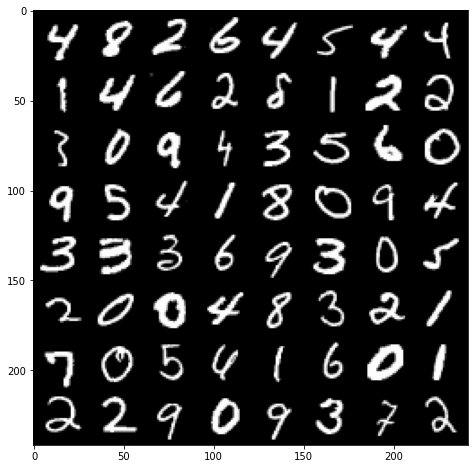

In [34]:
batch,labels = iter(train_iterator).next()
visualize_data(batch)

### Creating Model

In [35]:



class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicating the latent dimension.
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3,padding="same")

        #self.linear = nn.Linear(32*24*24, 512)
        self.linear = nn.Linear(32*7*7, 512)
        self.linear2 = nn.Linear(512, hidden_dim)

        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]
        # input size = 28 x 28 x 1
        # output size = 28 x 28 x 16
        x = F.relu(self.conv1(x))
        # Add a max pooling layer.
        # input size 28 x 28 x 16
        # output size 14 x 14 x 16
        #Output size= input_size - kernel_size +2*padding/strid + 1
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        # Add a 2D convolutional layer, with 32 feature maps.
        # input size = 14 x 14 x 16
        # output size = 14 x 14 x 32        
        
        x = F.relu(self.conv2(x))
        
        # Add a max pooling layer.
        # input size 14 x 14 x 32
        # output size 7 x 7 x 32
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        bs, ch, w,h = x.shape
        x = x.view(bs,ch*w*h)


        x = F.relu(self.linear(x))
        hidden = F.relu(self.linear2(x))

        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]

        return z_mu, z_var


In [36]:



class Encoder(nn.Module):
    ''' This the encoder part of VAE
    '''
    def __init__(self, hidden_dim, z_dim):
        '''
        Args:
            input_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
            hidden_dim: A integer indicating the size of hidden dimension.
            z_dim: A integer indicatinzg the latent dimension.
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)

        self.linear = nn.Linear(32*24*24, 512)
        self.linear2 = nn.Linear(512, hidden_dim)

        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        # x is of shape [batch_size, input_dim]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #print(x.shape, x)
        bs, ch, w,h = x.shape
        x = x.view(bs,ch*w*h)


        x = F.relu(self.linear(x))
        hidden = F.relu(self.linear2(x))
        
        # hidden is of shape [batch_size, hidden_dim]
        z_mu = self.mu(hidden)
        # z_mu is of shape [batch_size, latent_dim]
        z_var = self.var(hidden)
        # z_var is of shape [batch_size, latent_dim]
        return z_mu, z_var


In [37]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim):
        
        super().__init__()

        self.linear = nn.Linear(z_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 512 )
        #output = 7 * 7 * 32 = 1568
        self.linear3 = nn.Linear(512, 1568)#18432
        #stride*(size - 1) + k -2p
        self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride = 2)        
        
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2)

        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size = 3, stride= 1, padding = 1)

    def forward(self, x):
        # x is of shape [batch_size, latent_dim]
        # A fully-connected layer, to bulk things up to start.
        x = F.relu(self.linear(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = x.view(-1, 32, 7,7)
        # input size = 7 x 7 x 32
        # output size = 14 x 14 x 32
        x = F.relu(self.deconv1(x))
        # input size = 14 x 14 x 16
        # output size = 28 x 28 x 16
        x = F.relu(self.deconv2(x))
        predicted = torch.sigmoid(self.deconv3(x))
        #print(predicted.shape)
        # predicted is of shape [batch_size, output_dim]
        return predicted

In [38]:
class VAE(nn.Module):
    def __init__(self, enc, dec):
        ''' This the VAE, which takes a encoder and decoder.
        '''
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        z_mu, z_var = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)

        # decode
        predicted = self.dec(x_sample)
        #print(predicted.shape)
        return predicted, z_mu, z_var


In [39]:
# encoder
encoder = Encoder( HIDDEN_DIM, LATENT_DIM)

# decoder
decoder = Decoder(LATENT_DIM, HIDDEN_DIM)

# vae
model = VAE(encoder, decoder).cuda()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# xavier weight initialization
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

model.apply(init_xavier)

/tmp/ipykernel_2676338/341129117.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


VAE(
  (enc): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (linear): Linear(in_features=18432, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=10, bias=True)
    (var): Linear(in_features=256, out_features=10, bias=True)
  )
  (dec): Decoder(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=1568, bias=True)
    (deconv1): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (deconv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [40]:
print(model)

VAE(
  (enc): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (linear): Linear(in_features=18432, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (mu): Linear(in_features=256, out_features=10, bias=True)
    (var): Linear(in_features=256, out_features=10, bias=True)
  )
  (dec): Decoder(
    (linear): Linear(in_features=10, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=1568, bias=True)
    (deconv1): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
    (deconv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (deconv3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


### Training the Model

In [41]:
def train():
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0

    for i, (x, _) in enumerate(train_iterator):
        
        x = x.to(device)

        # update the gradients to zero
        optimizer.zero_grad()

        # forward pass
        x_sample, z_mu, z_var = model(x)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

        # kl divergence loss
        kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        # total loss
        loss = recon_loss + kl_loss

        # backward pass
        loss.backward()
        train_loss += loss.item()

        # update the weights
        optimizer.step()

    return train_loss

In [42]:
def test():
    # set the evaluation mode
    model.eval()

    # test loss for the data
    test_loss = 0

    with torch.no_grad():
        for i, (x, _) in enumerate(test_iterator):

            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x)

            # reconstruction loss
            recon_loss = F.binary_cross_entropy(x_sample, x, size_average=False)

            # kl divergence loss
            kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

            # total loss
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    return test_loss

In [43]:
def generate_data(bs=BATCH_SIZE):
    z = torch.randn(bs, LATENT_DIM).to(device)
    reconstructed_img = model.dec(z)
    img = reconstructed_img.view(-1,1,28, 28).data

    img = img.cpu()
    visualize_data(img)

In [44]:
N_EPOCHS = 40  

In [45]:
from tqdm import tqdm
trainLoss = []
testLoss = []

def fit():
    best_test_loss = float('inf')
    print('Before Training : ')
    generate_data()
    for e in tqdm(range(N_EPOCHS), desc="Processing", unit="iteration"):
        train_loss = train()
        test_loss = test()

        train_loss /= len(train_dataset)
        test_loss /= len(test_dataset)
        trainLoss.append(train_loss)
        testLoss.append(test_loss)
        print(f'Epoch {e}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')
        generate_data()
        '''
        if best_test_loss > test_loss:: This condition checks whether the current test loss is better (lower) than
        the best test loss encountered so far.

        If the current test_loss is better than the best_test_loss, it updates best_test_loss with the current
        test_loss.

        It also resets the patience_counter to 1. The patience_counter is a variable that counts how many consecutive
        times the test loss has not improved.

        If the current test_loss is not better than the best_test_loss, it means there's no improvement, and
        the patience_counter is incremented.

        if patience_counter > 3:: This checks whether the patience threshold has been exceeded. 
        In other words, it checks whether the test loss has not improved for more than 3 consecutive times.

        If the patience_counter is greater than 3, it means there has been no improvement for 3 consecutive 
        iterations, and the training loop is broken. This is a form of early stopping, as the algorithm stops 
        training if there is no improvement in the test loss for a specified number of consecutive epochs.
        
        The purpose of this logic is to stop the training loop early if the model is not making progress on 
        the test set, which can help prevent overfitting and save computational resources. The specific values 
        like 3 for patience and the use of the test loss for early stopping can be adjusted based on 
        the characteristics of your training process and dataset.
        '''
        if best_test_loss > test_loss:
            best_test_loss = test_loss
            patience_counter = 1
        else:
            patience_counter += 1

        if patience_counter > 3:
            break

### Saving The Weights of Best Model

Before Training : 


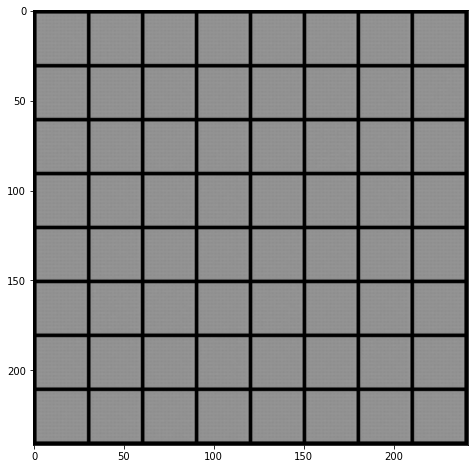

Processing:   0%|                                 | 0/40 [00:00<?, ?iteration/s]/home/setareh/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0, Train Loss: 171.34, Test Loss: 136.45


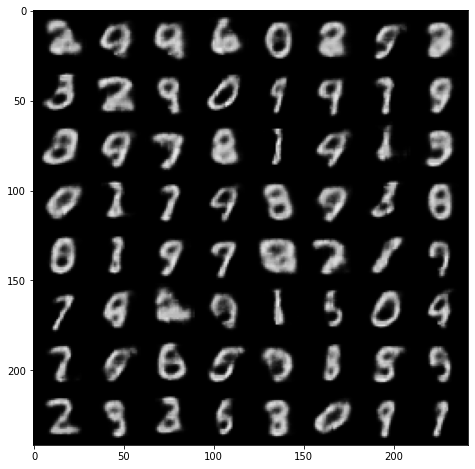

Processing:   2%|▋                        | 1/40 [00:07<04:42,  7.25s/iteration]

Epoch 1, Train Loss: 127.43, Test Loss: 122.98


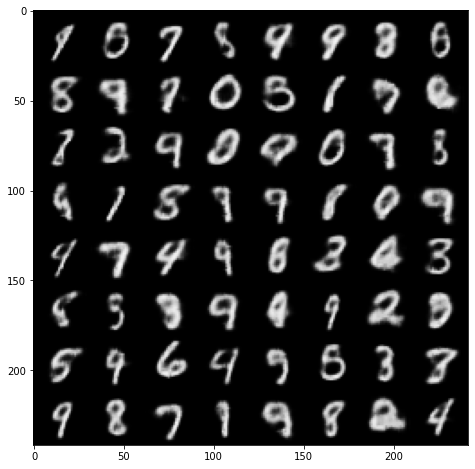

Processing:   5%|█▎                       | 2/40 [00:14<04:34,  7.22s/iteration]

Epoch 2, Train Loss: 120.85, Test Loss: 119.19


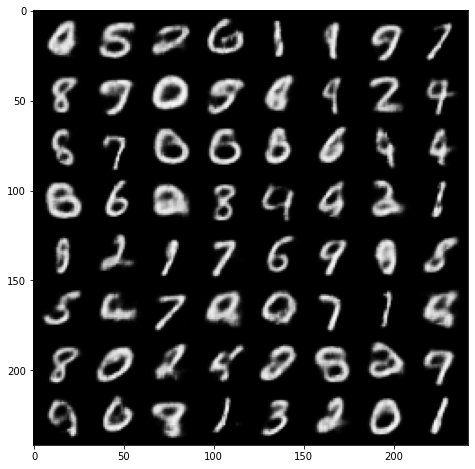

Processing:   8%|█▉                       | 3/40 [00:21<04:28,  7.26s/iteration]

Epoch 3, Train Loss: 115.74, Test Loss: 113.30


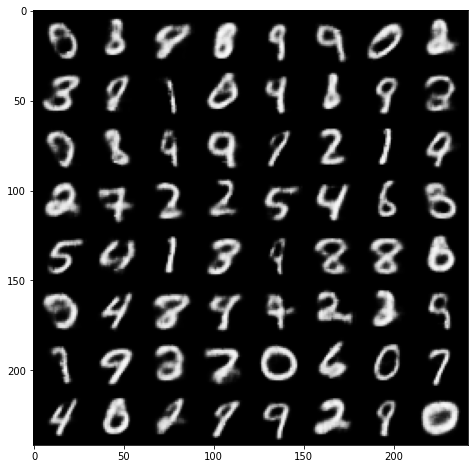

Processing:  10%|██▌                      | 4/40 [00:29<04:21,  7.28s/iteration]

Epoch 4, Train Loss: 112.68, Test Loss: 111.69


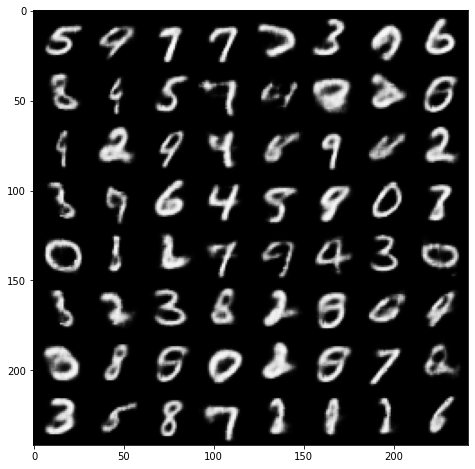

Processing:  12%|███▏                     | 5/40 [00:36<04:13,  7.25s/iteration]

Epoch 5, Train Loss: 110.88, Test Loss: 110.40


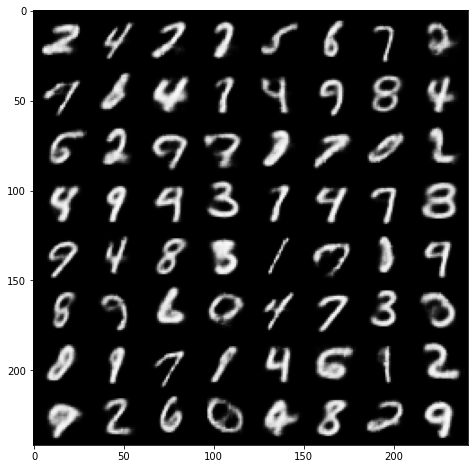

Processing:  15%|███▊                     | 6/40 [00:43<04:03,  7.18s/iteration]

Epoch 6, Train Loss: 109.54, Test Loss: 110.97


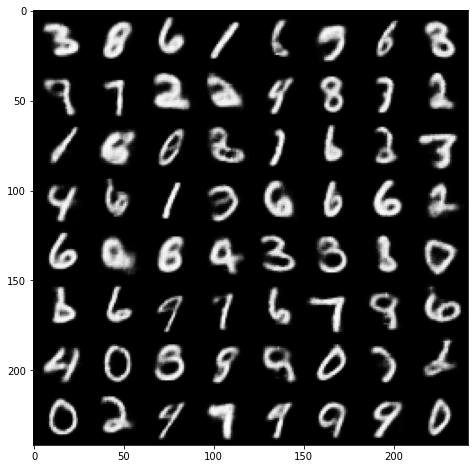

Processing:  18%|████▍                    | 7/40 [00:50<03:54,  7.11s/iteration]

Epoch 7, Train Loss: 108.51, Test Loss: 109.18


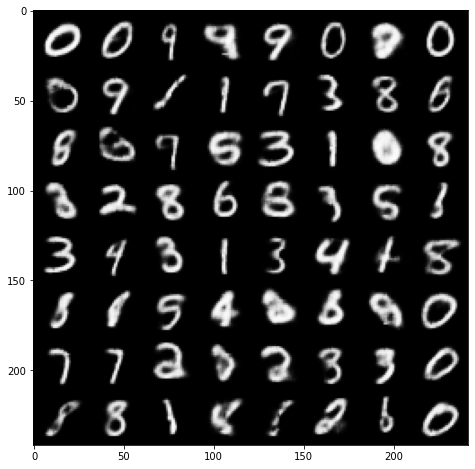

Processing:  20%|█████                    | 8/40 [00:57<03:46,  7.09s/iteration]

Epoch 8, Train Loss: 107.69, Test Loss: 108.15


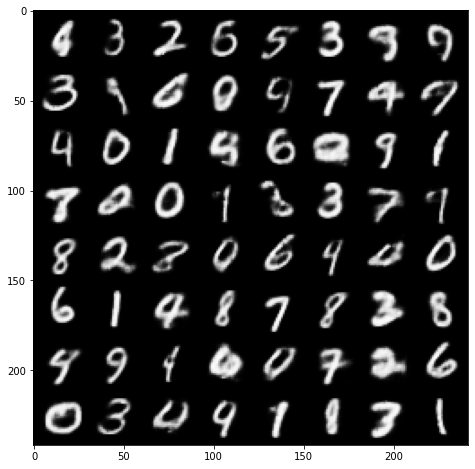

Processing:  22%|█████▋                   | 9/40 [01:04<03:38,  7.06s/iteration]

Epoch 9, Train Loss: 106.86, Test Loss: 107.18


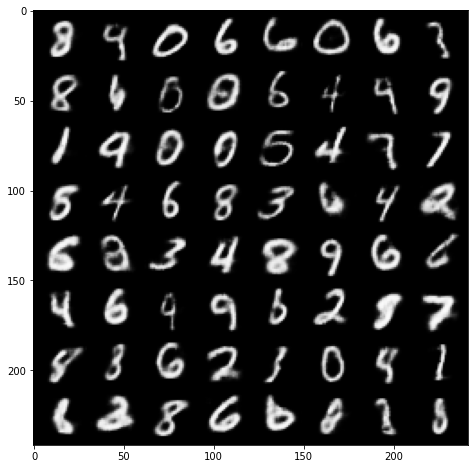

Processing:  25%|██████                  | 10/40 [01:11<03:30,  7.02s/iteration]

Epoch 10, Train Loss: 106.01, Test Loss: 107.36


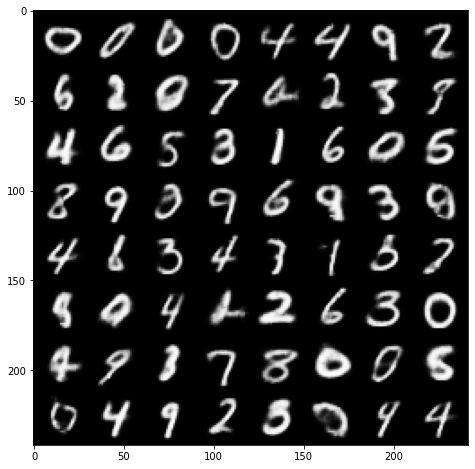

Processing:  28%|██████▌                 | 11/40 [01:18<03:23,  7.03s/iteration]

Epoch 11, Train Loss: 105.18, Test Loss: 107.40


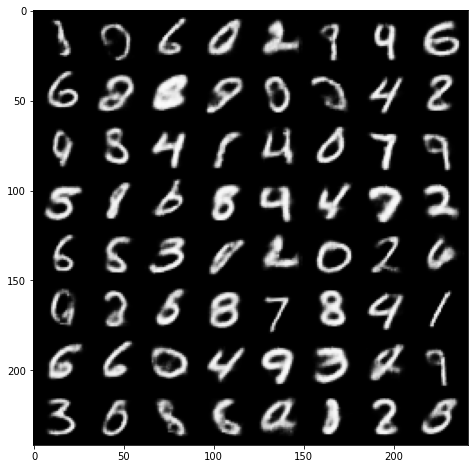

Processing:  30%|███████▏                | 12/40 [01:25<03:17,  7.04s/iteration]

Epoch 12, Train Loss: 104.47, Test Loss: 105.41


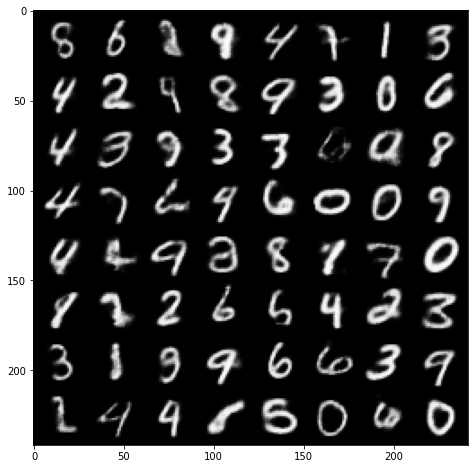

Processing:  32%|███████▊                | 13/40 [01:32<03:10,  7.06s/iteration]

Epoch 13, Train Loss: 103.82, Test Loss: 104.92


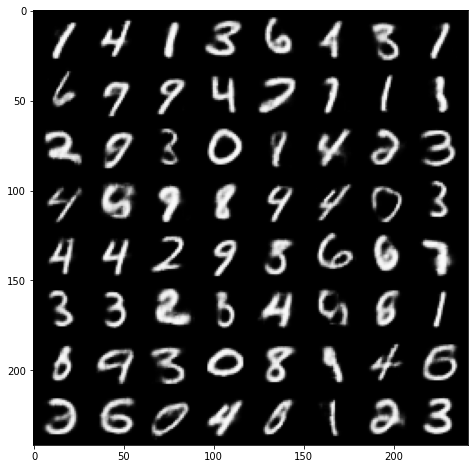

Processing:  35%|████████▍               | 14/40 [01:39<03:04,  7.08s/iteration]

Epoch 14, Train Loss: 103.28, Test Loss: 104.61


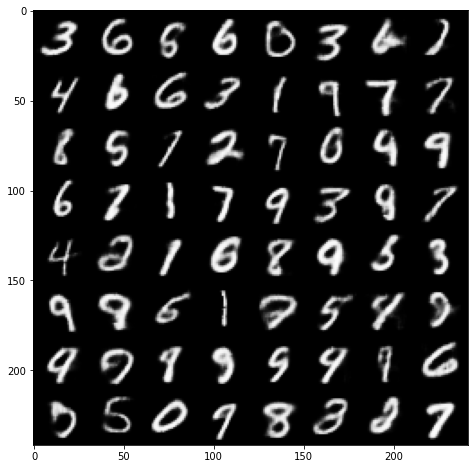

Processing:  38%|█████████               | 15/40 [01:46<02:57,  7.10s/iteration]

Epoch 15, Train Loss: 102.82, Test Loss: 104.67


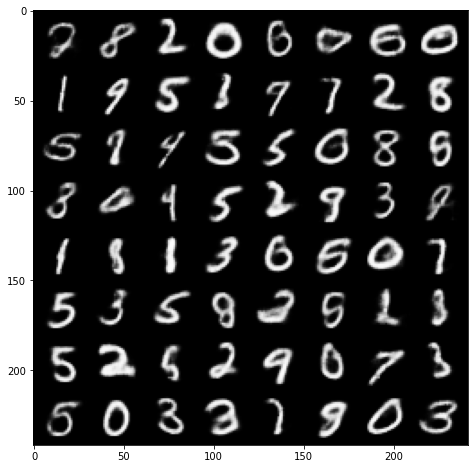

Processing:  40%|█████████▌              | 16/40 [01:53<02:49,  7.08s/iteration]

Epoch 16, Train Loss: 102.45, Test Loss: 104.40


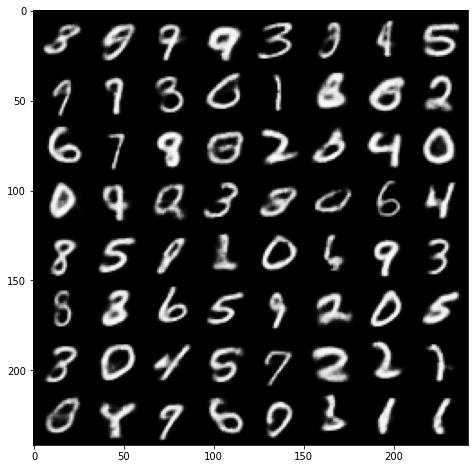

Processing:  42%|██████████▏             | 17/40 [02:00<02:42,  7.06s/iteration]

Epoch 17, Train Loss: 102.17, Test Loss: 104.03


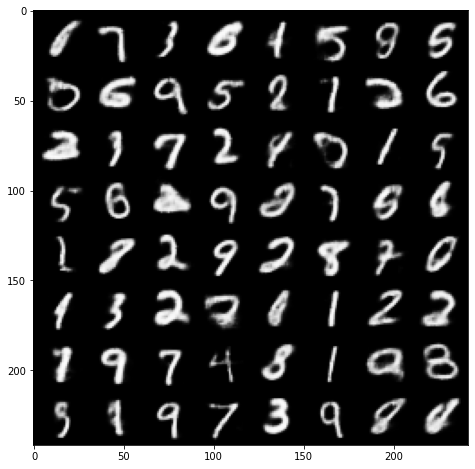

Processing:  45%|██████████▊             | 18/40 [02:07<02:34,  7.02s/iteration]

Epoch 18, Train Loss: 101.79, Test Loss: 103.75


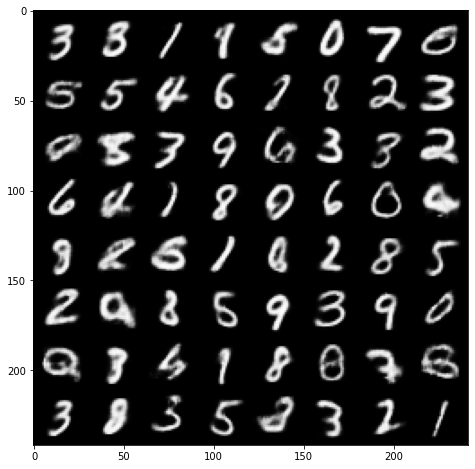

Processing:  48%|███████████▍            | 19/40 [02:14<02:28,  7.07s/iteration]

Epoch 19, Train Loss: 101.55, Test Loss: 104.15


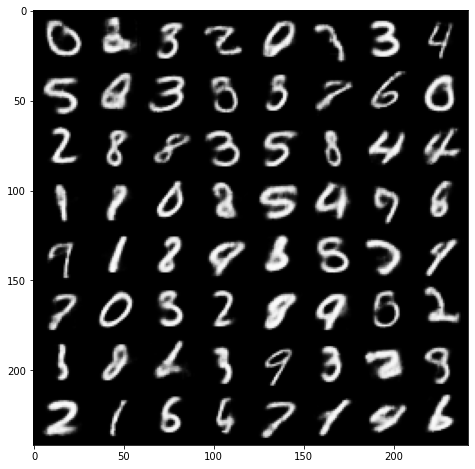

Processing:  50%|████████████            | 20/40 [02:22<02:22,  7.12s/iteration]

Epoch 20, Train Loss: 101.26, Test Loss: 104.61


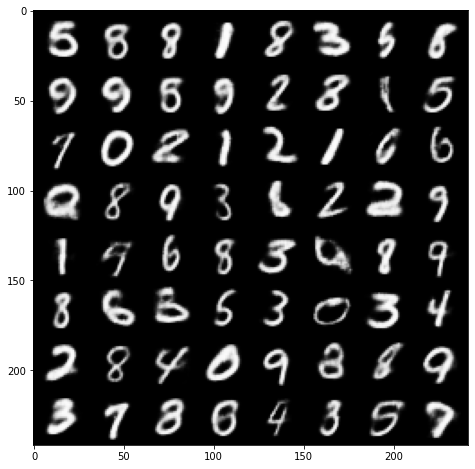

Processing:  52%|████████████▌           | 21/40 [02:29<02:16,  7.17s/iteration]

Epoch 21, Train Loss: 101.06, Test Loss: 103.50


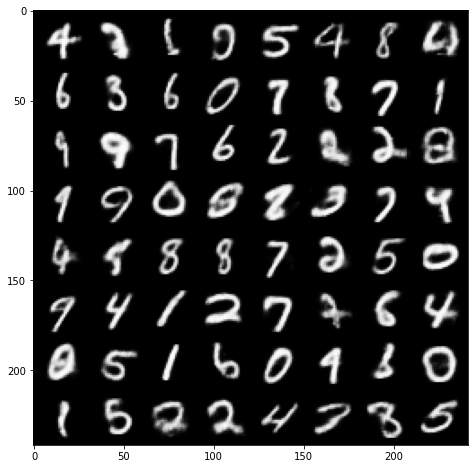

Processing:  55%|█████████████▏          | 22/40 [02:36<02:09,  7.21s/iteration]

Epoch 22, Train Loss: 100.84, Test Loss: 103.30


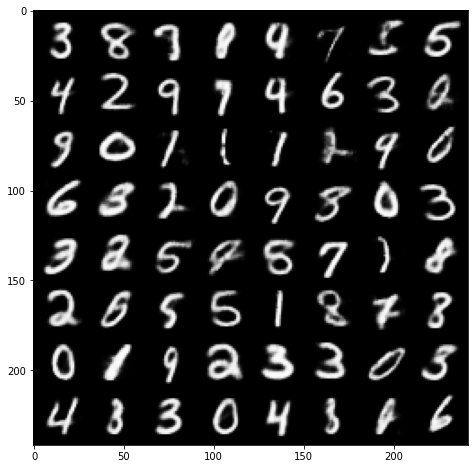

Processing:  57%|█████████████▊          | 23/40 [02:43<02:02,  7.22s/iteration]

Epoch 23, Train Loss: 100.63, Test Loss: 103.39


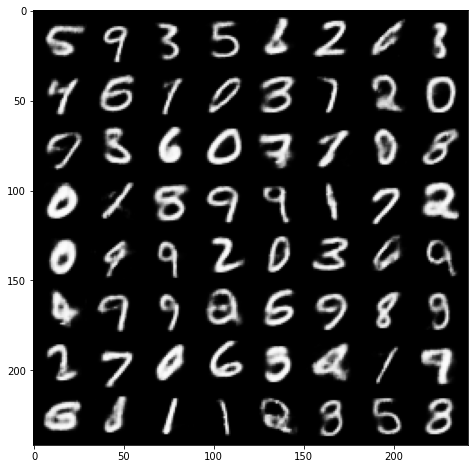

Processing:  60%|██████████████▍         | 24/40 [02:51<01:56,  7.26s/iteration]

Epoch 24, Train Loss: 100.42, Test Loss: 103.22


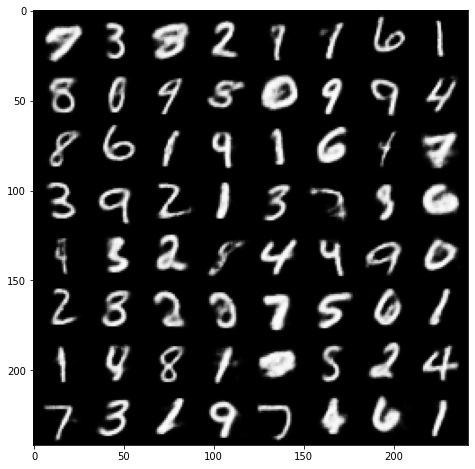

Processing:  62%|███████████████         | 25/40 [02:58<01:49,  7.28s/iteration]

Epoch 25, Train Loss: 100.24, Test Loss: 103.38


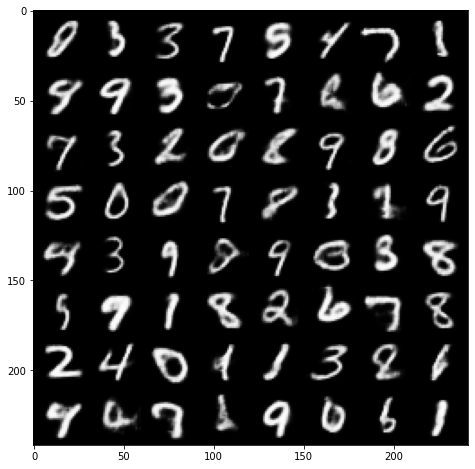

Processing:  65%|███████████████▌        | 26/40 [03:05<01:42,  7.30s/iteration]

Epoch 26, Train Loss: 100.07, Test Loss: 102.84


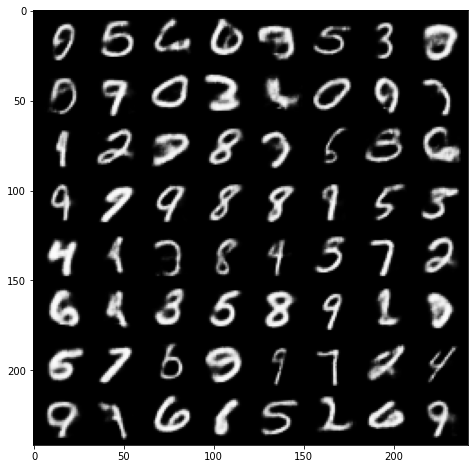

Processing:  68%|████████████████▏       | 27/40 [03:13<01:35,  7.36s/iteration]

Epoch 27, Train Loss: 99.92, Test Loss: 103.15


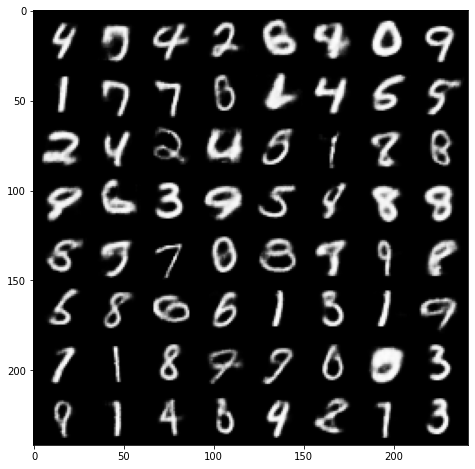

Processing:  70%|████████████████▊       | 28/40 [03:20<01:28,  7.36s/iteration]

Epoch 28, Train Loss: 99.77, Test Loss: 103.05


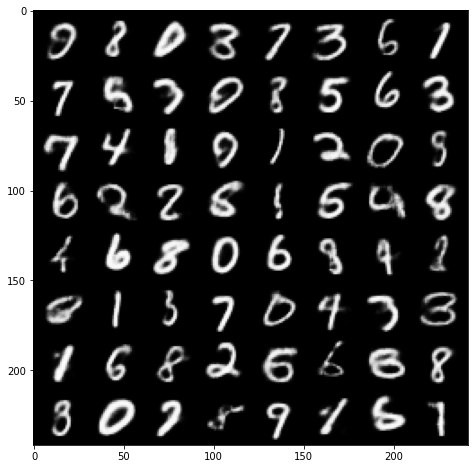

Processing:  72%|█████████████████▍      | 29/40 [03:28<01:20,  7.34s/iteration]

Epoch 29, Train Loss: 99.63, Test Loss: 103.42


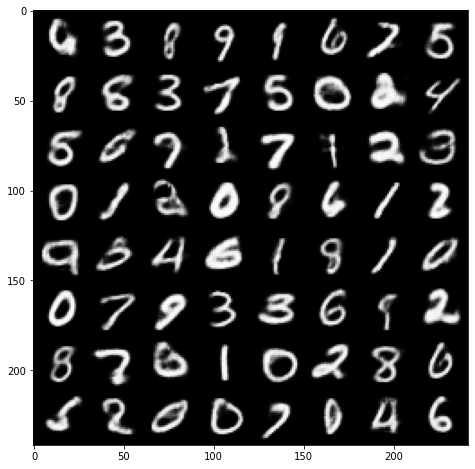

Processing:  72%|█████████████████▍      | 29/40 [03:35<01:21,  7.43s/iteration]


In [46]:
fit()     




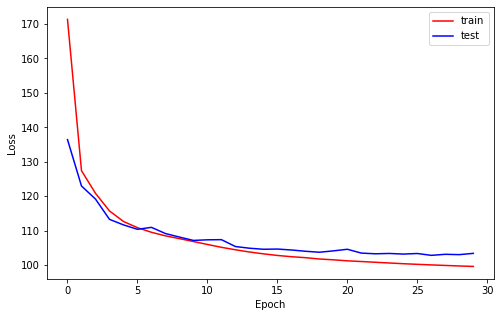

In [52]:
sns.set_palette("tab10")


from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(8,5))


plt.plot(range(30),trainLoss, c="red", label="train")
plt.plot(range(30),testLoss, c="blue", label="test")
plt.xlabel(r"Epoch")
plt.ylabel(r"Loss")
plt.legend()


plt.show()

### Generating grid of data Using VAE Model

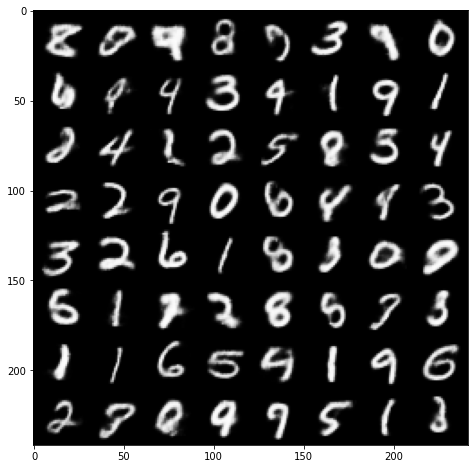

In [54]:
generate_data() # This function defined above will generate Batch Data 

### Get Latent data

In [47]:
def get_latent_data(data_iterator):

    means = np.zeros((1,10))
    vars = np.zeros((1,10))

    data_labels = []
    with torch.no_grad():
        for batch, labels in data_iterator:
            labels = list(labels.numpy())
            batch = batch.to(device)
            mean, var = model.enc(batch)
            
            mean = mean.to('cpu').numpy()
            var = var.to('cpu').numpy()

            means = np.vstack((means,mean))
            vars = np.vstack((vars, var))
            data_labels.extend(labels)

    means = means[1:]
    vars = vars[1:]

    return means, vars, data_labels

In [48]:
train_means, train_vars, train_labels = get_latent_data(train_iterator)

### TSNE 
t-SNE, or t-Distributed Stochastic Neighbor Embedding, is a machine learning technique used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is particularly useful for exploring and understanding the underlying structure of complex datasets.

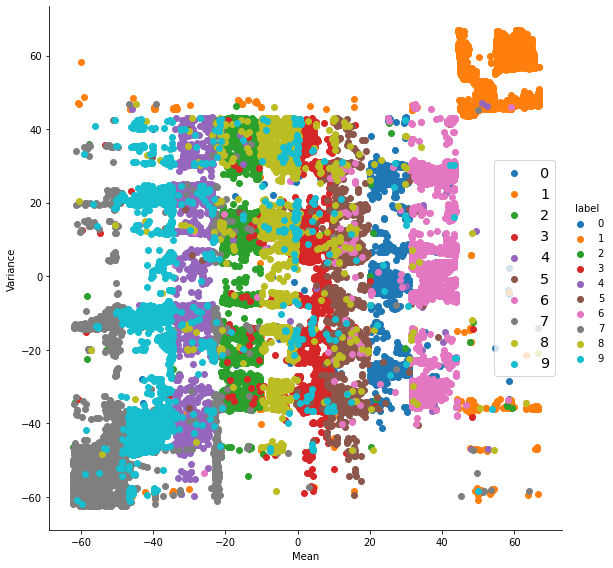

In [0]:

mean_tsne = TSNE(n_components = 1, random_state = 0)
var_tsne = TSNE(n_components = 1, random_state = 0)

tsne_mean = mean_tsne.fit_transform(train_means)
tsne_var = var_tsne.fit_transform(train_vars)


df = pd.DataFrame()
df['Mean'] = tsne_mean.squeeze(1)
df['Variance'] = tsne_var.squeeze(1)
df['label'] = train_labels

g = sns.FacetGrid(df, hue = 'label', height = 8).map(plt.scatter, 'Mean','Variance').add_legend()
plt.legend(fontsize='x-large', title_fontsize='40',loc = 'best')

plt.show()


### Getting latent data for test data

In [0]:
train_latent_data = np.column_stack((train_means, train_vars))
train_latent_df = pd.DataFrame(train_latent_data)  
train_labels = np.array(train_labels)

# test latent data 
test_means, test_vars, test_labels = get_latent_data(test_iterator)

test_latent_data = np.column_stack((test_means, test_vars))
test_latent_df = pd.DataFrame(test_latent_data)  
test_labels = np.array(test_labels)



In [0]:
print('Shape of Training data : ', train_latent_data.shape)
print('Shape of Testing Data : ', test_latent_data.shape)

Shape of Training data :  (60000, 20)
Shape of Testing Data :  (10000, 20)


### Training the SVM classifier on Latent Space

In [0]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(train_latent_df, train_labels)

# prediction on test data

ypreds = clf.predict(test_latent_df)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


In [0]:
def plot_confusion_matrix(cm, title, filepath):

    df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                      columns = [i for i in "0123456789"])

    plt.figure(figsize = (8,5))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title(title)
    #plt.savefig(filepath)
    plt.show()

In [0]:
test_acc = accuracy_score(ytrue, ypreds)
f_score = f1_score(ytrue, ypreds, average='macro')

prec = precision_score(ytrue, ypreds, average='macro')
recall = recall_score(ytrue, ypreds, average='macro')

cm = confusion_matrix(ytrue, ypreds)

In [0]:
print('Test Accuracy : ', test_acc)
print('Test prec : ', prec)
print('Test Recall : ', recall)
print('Test Data F - Score : ', f_score)


Test Accuracy :  0.9316
Test prec :  0.9316184285117484
Test Recall :  0.9309966925068466
Test Data F - Score :  0.9310271278772506


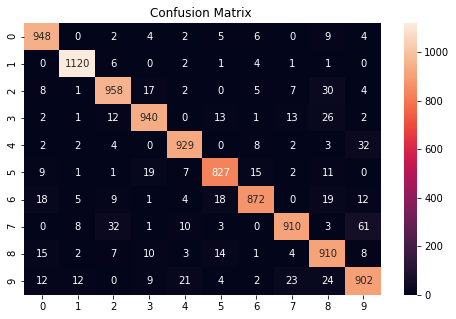

In [0]:
plot_confusion_matrix(cm, 'Confusion Matrix ','dummy')